# ResNet from Scratch in PyTorch

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms

from collections import OrderedDict
import os
import multiprocessing

In [2]:
#!pip install -r requirements.txt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Print the type of the GPU used
print("GPU Model: ", torch.cuda.get_device_name(0))

# Print CPU Information
print("CPU ", end='')
os.system("cat /proc/cpuinfo | grep 'model name' | uniq");
print("CPU Count: ", multiprocessing.cpu_count())

GPU Model:  NVIDIA GeForce RTX 3070 Laptop GPU
CPU model name	: 12th Gen Intel(R) Core(TM) i7-12650H
CPU Count:  16


In [5]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## ResNet Architecture Definition

In [6]:
from src.custom_layers import ResidualBlock, get_conv_layer, get_fc_layer

In [7]:
class ResNet(nn.Module):
    def __init__(self, res_block_layers, num_classes = 10):
        super(ResNet, self).__init__()
        layers = OrderedDict([
                ("conv_layer", get_conv_layer(3, res_block_layers[0]['out_channels'] , kernel_size=7, stride=2, padding=3))
            ]
        )
        layers["max_pool"] = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        in_channels = res_block_layers[0]['out_channels']
        for i, layer in enumerate(res_block_layers):
            layers[f"res_layer_{i}"] = OrderedDict()
            res_blocks = OrderedDict()
            res_blocks["res_block_0"] = ResidualBlock(in_channels, layer['out_channels'], stride=layer['stride'])
            in_channels = layer["out_channels"]
            for j in range(1, layer["num_blocks"]):
                res_blocks[f"res_block_{j}"] = ResidualBlock(in_channels, layer['out_channels'], stride=1)

            layers[f"res_layer_{i}"] = nn.Sequential(res_blocks)
            
        layers['avgpool'] = nn.AvgPool2d(7, stride=1)
        layers['flatten'] = nn.Flatten()
        layers['fc'] = nn.Linear(in_channels, num_classes)
        
        self.model = nn.Sequential(layers)
    
    def forward(self, x):
        return self.model(x)

## Training

In [7]:
num_classes = 10
num_epochs = 10
batch_size = 128
learning_rate = 0.01

model_save_path = "checkpoints/best_resnet18_model.pt"

In [8]:
from src.data import get_data_loaders

gpu_kwargs = {
    "persistent_workers": True, 
    "pin_memory": True, 
    "pin_memory_device": 'cuda:0', 
    "prefetch_factor": 8
}

data_loaders = get_data_loaders(
                                data_dir="./data", 
                                batch_size=batch_size, 
                                subset_fraction=1, # Modify this value to include fractions of the dataset. Setting it to 1 will use the whole dataset.
                                num_workers=multiprocessing.cpu_count(), 
                                **gpu_kwargs
                               )


Files already downloaded and verified
Files already downloaded and verified


In [9]:
res_block_layers = [
    {"num_blocks": 3, "out_channels": 64, "stride": 1},
    {"num_blocks": 4, "out_channels": 128 , "stride": 2},
    {"num_blocks": 6, "out_channels": 256, "stride": 2},
    {"num_blocks": 3, "out_channels": 512, "stride": 2},
]

model = ResNet(res_block_layers, num_classes=num_classes).to(device)

if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path))

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

In [11]:
common_transforms = [
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
]

# # Other data augmentation to try for the training dataset
# train_transforms = [
#                 transforms.RandomAffine(scale=(0.9, 1.1), translate=(0.1, 0.1), degrees=10, fill=0, interpolation=transforms.InterpolationMode.BILINEAR),
#                 transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
#                 transforms.RandomHorizontalFlip(0.5),
#             ]

In [12]:
transformations = {
    "train": common_transforms, # + train_transforms
    "valid": common_transforms,
    "test": common_transforms
}

In [14]:
from src.train import training_loop

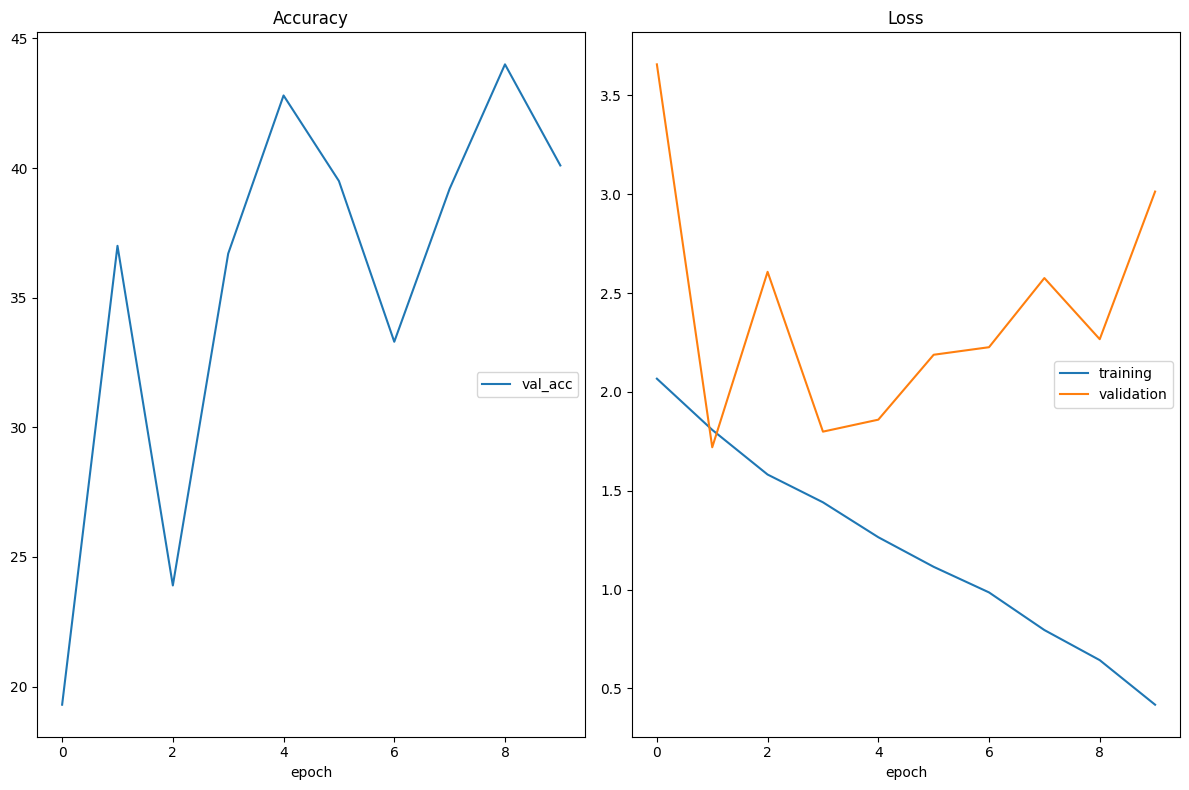

Epoch [10/10], Training Loss: 0.4180, Validation Loss: 3.0134, Validation Accuracy: 40.10%


In [15]:
training_loop(model, device, data_loaders, optimizer, criterion, num_epochs, model_save_path, transformations)

## Testing Your Model

In [14]:
from src.train import test_one_epoch

In [16]:
# Load best weights
if os.path.exists(model_save_path):
    model.load_state_dict(torch.load(model_save_path))
    
test_loss, test_accuracy = test_one_epoch(
    model, 
    device, data_loaders["test"], 
    optimizer, 
    criterion, 
    description="Testing", 
    transformations=transforms.Compose(common_transforms)
)

print ('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, 100 * test_accuracy))

Testing: 100%|██████████████████████████████████| 79/79 [01:08<00:00,  1.16it/s]

Test Loss: 1.7833, Test Accuracy: 36.02%


## Examining the Network

In [8]:
from src.data import get_data_loaders
data_loaders = get_data_loaders(data_dir="./data", batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Get a batch of data
X, y = next(iter(data_loaders["train"]))

In [10]:
res_block_layers = [
    {"num_blocks": 3, "out_channels": 64, "stride": 1},
    {"num_blocks": 4, "out_channels": 128 , "stride": 2},
    {"num_blocks": 6, "out_channels": 256, "stride": 2},
    {"num_blocks": 3, "out_channels": 512, "stride": 2},
]

resnet18 = ResNet(res_block_layers)

In [12]:
resnet18

ResNet(
  (model): Sequential(
    (conv_layer): Sequential(
      (conv_block): Sequential(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (res_layer_0): Sequential(
      (res_block_0): ResidualBlock(
        (conv_block): Sequential(
          (conv1): Sequential(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU()
          )
          (conv2): Sequential(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          

In [13]:
layers_lst = list()
def get_children(layer, level=0):
    global layers_lst
    named_children = list(layer.named_children())
    for name, child in named_children:
        is_leaf_node = len(list(child.named_children())) == 0
        layers_lst.append({"name": name, "layer": child, "level": level, "is_leaf_node": is_leaf_node})
        get_children(child, level+1)

In [14]:
get_children(resnet18.model)

In [15]:
out = X
for layer in layers_lst:
    print_message = layer["level"] * "\t" + "{0:15s}".format("(" + layer["name"]+ "),")
    if layer["is_leaf_node"] and not layer["name"].startswith("downsample_"):
        out = layer["layer"](out)
        print_message += f"Output shape: {list(out.shape)}"
    print(print_message)

(conv_layer),  
	(conv_block),  
		(conv),        Output shape: [32, 64, 112, 112]
		(batch_norm),  Output shape: [32, 64, 112, 112]
		(relu),        Output shape: [32, 64, 112, 112]
(max_pool),    Output shape: [32, 64, 56, 56]
(res_layer_0), 
	(res_block_0), 
		(conv_block),  
			(conv1),       
				(conv),        Output shape: [32, 64, 56, 56]
				(batch_norm),  Output shape: [32, 64, 56, 56]
				(relu),        Output shape: [32, 64, 56, 56]
			(conv2),       
				(conv),        Output shape: [32, 64, 56, 56]
				(batch_norm),  Output shape: [32, 64, 56, 56]
		(relu),        Output shape: [32, 64, 56, 56]
	(res_block_1), 
		(conv_block),  
			(conv1),       
				(conv),        Output shape: [32, 64, 56, 56]
				(batch_norm),  Output shape: [32, 64, 56, 56]
				(relu),        Output shape: [32, 64, 56, 56]
			(conv2),       
				(conv),        Output shape: [32, 64, 56, 56]
				(batch_norm),  Output shape: [32, 64, 56, 56]
		(relu),        Output shape: [32, 64, 56, 56]
	(res_block_2

In [11]:
# Model complexity - calculating the total number of parameters
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
trainable_params

21298314

### Visualize your network

You can visualize the architecture using netron.app. Execute following cell to create `resnet18_network.pt` file. Then, go to [Netron.app](https://netron.app/) and click on Open Model, and select the file that was generated.

In [ ]:
scripted = torch.jit.trace(resnet18, X)

In [ ]:
torch.jit.save(scripted, "visualization/resnet18_network.pt")

### Visualize The Computation Graph

In [ ]:
from torchviz import make_dot

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
A = resnet18(X)

In [ ]:
loss = criterion(A, y)

In [ ]:
make_dot(
    loss, 
    params=dict(list(resnet18.named_parameters())), 
    show_attrs=True, 
    show_saved=True
).render("visualization/resnet18_model", format="svg")